In [1]:
# ⚙️ Preparación de entorno y rutas
# Si esta celda tarda demasiado o se cuelga:
# 1) Abre la paleta de comandos (Ctrl+Shift+P)
# 2) "Jupyter: Restart Kernel"
# 3) "Run All Above/Below" o ejecuta desde la primera celda

import sys
from pathlib import Path

# Detectar raíz del repo (buscando pyproject.toml o carpeta src)
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()

if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))

print(f"✅ Entorno listo. Raíz del repo: {_repo_root}")

✅ Entorno listo. Raíz del repo: f:\GitHub\supply-chain-data-notebooks


# DA-01: Diseño de Modelo Dimensional para Analítica de Inventarios

## 📋 Contexto del Caso de Negocio

**Empresa:** Cadena de retail nacional "SuperRetail" con 30 centros de distribución y 200 tiendas.

**Situación:** La empresa tiene datos de inventario dispersos en múltiples sistemas operacionales (WMS, ERP, TMS). Los analistas necesitan responder preguntas como:
- ¿Cuál es la rotación de inventario por categoría y ubicación?
- ¿Qué productos tienen mayor cobertura (días de inventario)?
- ¿Dónde están los inventarios obsoletos o de lento movimiento?
- ¿Cómo evoluciona el valor del inventario mes a mes?

**Objetivo:** Diseñar e implementar un modelo dimensional (esquema estrella) que permita análisis OLAP rápidos y flexibles.

---

## 🎯 Qué - Por qué - Para qué - Cuándo - Cómo

### ❓ ¿QUÉ estamos haciendo?
Diseñando un **modelo dimensional tipo estrella** con:
- **Tabla de hechos:** `fact_inventory_daily` con métricas diarias de inventario
- **Dimensiones:** `dim_date`, `dim_product`, `dim_location`, `dim_product_category`
- **Métricas calculadas:** rotación, cobertura, valor inventario, unidades disponibles

### 🔍 ¿POR QUÉ es importante?
- **Velocidad:** El esquema estrella optimiza queries analíticas (menos JOINs)
- **Simplicidad:** Los analistas de negocio pueden navegar intuitivamente
- **Historización:** Las dimensiones tipo SCD (Slowly Changing Dimension) preservan historia
- **Agregaciones:** Facilita cubos OLAP y reportes drill-down

### 🎁 ¿PARA QUÉ sirve?
- Dashboards ejecutivos de inventario (BI)
- Análisis ABC/XYZ de productos
- Detección de obsolescencia y slow-movers
- Input para modelos de optimización de inventario
- Auditorías y reconciliaciones contables

### ⏰ ¿CUÁNDO aplicarlo?
- **Cuando hay múltiples fuentes** de datos de inventario que necesitan consolidarse
- **Cuando los queries son lentos** en el modelo transaccional normalizado
- **Cuando necesitas análisis históricos** con comparaciones temporales
- **Cuando diferentes áreas** (finanzas, operaciones, comercial) consultan los mismos datos

### 🛠️ ¿CÓMO lo hacemos?
1. **Análisis de requerimientos:** Identificar preguntas de negocio y KPIs
2. **Definir granularidad:** SKU x Ubicación x Día
3. **Identificar dimensiones:** Tiempo, Producto, Ubicación, Categoría
4. **Definir métricas:** Qty on-hand, valor, entradas, salidas, rotación
5. **Diseñar claves:** Surrogate keys (SK) vs natural keys
6. **Implementar ETL:** Cargar dimensiones y hechos desde sources
7. **Validar:** Queries de prueba y reconciliación con fuentes

---\nid: "DA-01"\ntitle: "Modelo Dimensional para Supply Chain"\nspecialty: "Data Architecture"\nprocess: "Design"\nlevel: "Intermediate"\ntags: ["dimensional", "star-schema", "warehouse", "sql"]\nestimated_time_min: 60\n---\n

In [2]:
# Imports necesarios
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Librerías cargadas")

✅ Librerías cargadas


## 📥 Paso 1: Cargar datos transaccionales (fuentes)

Simulamos la carga desde sistemas operacionales (WMS, ERP).

In [3]:
from pathlib import Path
import pandas as pd
from datetime import datetime

data_path = Path('../../data/raw')

# Cargar datasets sintéticos (fallback robusto de fechas)
df_inventory = pd.read_csv(data_path / 'inventory.csv')

# Normalizar columnas clave esperadas
# Detectar/estandarizar columna de fecha
date_cols = [c for c in ['date', 'inventory_date', 'ds', 'fecha', 'day'] if c in df_inventory.columns]
if date_cols:
    c = date_cols[0]
    df_inventory[c] = pd.to_datetime(df_inventory[c], errors='coerce')
    if c != 'date':
        df_inventory.rename(columns={c: 'date'}, inplace=True)
else:
    # Si no hay columna de fecha, crear una por defecto (hoy) para permitir el modelo dimensional
    df_inventory['date'] = pd.to_datetime(datetime.utcnow().date())

# Estandarizar cantidad on hand y derivados
if 'qty_on_hand' not in df_inventory.columns:
    # Renombrar si viene como 'on_hand' u otra variante común
    for alt in ['on_hand', 'quantity_on_hand', 'stock_on_hand', 'qty']: 
        if alt in df_inventory.columns:
            df_inventory.rename(columns={alt: 'qty_on_hand'}, inplace=True)
            break
# Crear columnas reservadas y disponibles si faltan
if 'qty_reserved' not in df_inventory.columns:
    df_inventory['qty_reserved'] = 0
if 'qty_available' not in df_inventory.columns:
    # Disponible = on_hand - reserved, tope inferior 0
    df_inventory['qty_available'] = (df_inventory['qty_on_hand'] - df_inventory['qty_reserved']).clip(lower=0)

# Asegurar claves naturales esperadas
# sku
if 'sku' not in df_inventory.columns:
    for alt in ['product_sku', 'item_sku', 'item_id', 'product_id']:
        if alt in df_inventory.columns:
            df_inventory.rename(columns={alt: 'sku'}, inplace=True)
            break
# location_id
if 'location_id' not in df_inventory.columns:
    for alt in ['loc_id', 'warehouse_id', 'store_id', 'location']:
        if alt in df_inventory.columns:
            df_inventory.rename(columns={alt: 'location_id'}, inplace=True)
            break

# Cargar maestros
df_products = pd.read_csv(data_path / 'products.csv')
df_locations = pd.read_csv(data_path / 'locations.csv')

print('✅ Datos cargados:', df_inventory.shape, df_products.shape, df_locations.shape)
print('Columnas inventario:', list(df_inventory.columns))

✅ Datos cargados: (3000, 6) (200, 4) (30, 4)
Columnas inventario: ['location_id', 'sku', 'qty_on_hand', 'date', 'qty_reserved', 'qty_available']


## 🏗️ Paso 2: Construir Dimensión Tiempo (dim_date)

La dimensión tiempo es fundamental en modelos dimensionales. Incluye atributos calendáricos para facilitar análisis temporales.

In [4]:
# Crear dimensión de tiempo
def build_date_dimension(start_date, end_date):
    """
    Genera tabla de dimensión de fechas con atributos calendáricos.
    """
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    dim_date = pd.DataFrame({
        'date_key': date_range.strftime('%Y%m%d').astype(int),  # Surrogate key
        'date': date_range,
        'year': date_range.year,
        'quarter': date_range.quarter,
        'month': date_range.month,
        'month_name': date_range.strftime('%B'),
        'week': date_range.isocalendar().week,
        'day_of_month': date_range.day,
        'day_of_week': date_range.dayofweek,
        'day_name': date_range.strftime('%A'),
        'is_weekend': date_range.dayofweek.isin([5, 6]).astype(int),
        'is_month_start': date_range.is_month_start.astype(int),
        'is_month_end': date_range.is_month_end.astype(int)
    })
    
    return dim_date

# Construir dimensión
min_date = df_inventory['date'].min()
max_date = df_inventory['date'].max()

dim_date = build_date_dimension(min_date, max_date)

print(f"📅 Dimensión tiempo creada: {len(dim_date)} días")
print(f"📅 Rango: {min_date.date()} a {max_date.date()}")
print("\n🔍 Sample:")
dim_date.head()

📅 Dimensión tiempo creada: 1 días
📅 Rango: 2025-12-01 a 2025-12-01

🔍 Sample:


,date_key,date,year,quarter,month,month_name,week,day_of_month,day_of_week,day_name,is_weekend,is_month_start,is_month_end
2025-12-01,20251201,2025-12-01,2025,4,12,December,49,1,0,Monday,0,1,0


## 🏷️ Paso 3: Construir Dimensión Producto (dim_product)

Incluye jerarquías de categorización para drill-down/roll-up.

In [5]:
# Dimensión producto con jerarquía (robusta a columnas faltantes)
dim_product = df_products.copy()
dim_product['product_key'] = range(1, len(dim_product) + 1)  # Surrogate key

# Asegurar columnas esperadas con defaults si faltan
expected_cols = {
    'sku': None,
    'product_name': 'UNKNOWN',
    'category': 'UNCATEGORIZED',
    'subcategory': 'GENERAL',
    'brand': 'NO_BRAND',
    'unit_cost': 0.0,
    'unit_price': 0.0,
    'weight_kg': 0.0,
    'is_active': 1,
}
for col, default in expected_cols.items():
    if col not in dim_product.columns:
        dim_product[col] = default

# Reordenar columnas con SK primero (filtrando solo las que existan)
ordered = ['product_key', 'sku', 'product_name', 'category', 'subcategory',
           'brand', 'unit_cost', 'unit_price', 'weight_kg', 'is_active']
existing_ordered = [c for c in ordered if c in dim_product.columns]
dim_product = dim_product[existing_ordered]

print(f"🏷️ Dimensión producto creada: {len(dim_product)} SKUs")
print(f"📊 Categorías: {dim_product['category'].nunique()}")
print(f"📊 Subcategorías: {dim_product['subcategory'].nunique()}")
print("\n🔍 Sample:")
dim_product.head(3)

🏷️ Dimensión producto creada: 200 SKUs
📊 Categorías: 5
📊 Subcategorías: 1

🔍 Sample:


,product_key,sku,product_name,category,subcategory,brand,unit_cost,unit_price,weight_kg,is_active
0,1,SKU-00001,UNKNOWN,Household,GENERAL,BrandB,56.62,0.0,0.0,1
1,2,SKU-00002,UNKNOWN,Electronics,GENERAL,BrandC,114.89,0.0,0.0,1
2,3,SKU-00003,UNKNOWN,PersonalCare,GENERAL,BrandA,7.09,0.0,0.0,1


## 📍 Paso 4: Construir Dimensión Ubicación (dim_location)

Incluye jerarquía geográfica: región > ciudad > ubicación.

In [6]:
# Dimensión ubicación (robusta a columnas faltantes)
dim_location = df_locations.copy()
dim_location['location_key'] = range(1, len(dim_location) + 1)  # Surrogate key

# Asegurar columnas esperadas con defaults si faltan
expected_cols = {
    'location_id': None,
    'location_name': 'UNKNOWN_LOC',
    'location_type': 'UNKNOWN',
    'region': 'UNSPECIFIED',
    'city': 'UNSPECIFIED',
    'capacity_units': 0,
    'is_active': 1,
}
for col, default in expected_cols.items():
    if col not in dim_location.columns:
        dim_location[col] = default

# Reordenar columnas
ordered = ['location_key', 'location_id', 'location_name', 'location_type',
           'region', 'city', 'capacity_units', 'is_active']
existing_ordered = [c for c in ordered if c in dim_location.columns]
dim_location = dim_location[existing_ordered]

print(f"📍 Dimensión ubicación creada: {len(dim_location)} ubicaciones")
print(f"📊 Tipos: {dim_location['location_type'].value_counts().to_dict()}")
print(f"📊 Regiones: {dim_location['region'].nunique()}")
print("\n🔍 Sample:")
dim_location.head(3)

📍 Dimensión ubicación creada: 30 ubicaciones
📊 Tipos: {'UNKNOWN': 30}
📊 Regiones: 5

🔍 Sample:


,location_key,location_id,location_name,location_type,region,city,capacity_units,is_active
0,1,LOC-001,UNKNOWN_LOC,UNKNOWN,SOUTH,UNSPECIFIED,0,1
1,2,LOC-002,UNKNOWN_LOC,UNKNOWN,EAST,UNSPECIFIED,0,1
2,3,LOC-003,UNKNOWN_LOC,UNKNOWN,EAST,UNSPECIFIED,0,1


## 📊 Paso 5: Construir Tabla de Hechos (fact_inventory_daily)

La tabla de hechos contiene métricas numéricas a la granularidad definida: **SKU x Ubicación x Día**.

In [7]:
# Crear tabla de hechos (robusta a columnas faltantes)
fact_inventory = df_inventory.copy()

# Asegurar columnas de cantidades
if 'qty_on_hand' not in fact_inventory.columns:
    # intentar derivar de alguna variante o default 0
    for alt in ['on_hand', 'quantity_on_hand', 'stock_on_hand', 'qty']:
        if alt in fact_inventory.columns:
            fact_inventory.rename(columns={alt: 'qty_on_hand'}, inplace=True)
            break
    if 'qty_on_hand' not in fact_inventory.columns:
        fact_inventory['qty_on_hand'] = 0
if 'qty_reserved' not in fact_inventory.columns:
    fact_inventory['qty_reserved'] = 0
if 'qty_available' not in fact_inventory.columns:
    fact_inventory['qty_available'] = (fact_inventory['qty_on_hand'] - fact_inventory['qty_reserved']).clip(lower=0)

# Join con dimensiones para obtener surrogate keys
fact_inventory = fact_inventory.merge(
    dim_date[['date', 'date_key']], on='date', how='left'
)

fact_inventory = fact_inventory.merge(
    dim_product[['sku', 'product_key']], on='sku', how='left'
)

fact_inventory = fact_inventory.merge(
    dim_location[['location_id', 'location_key']], on='location_id', how='left'
)

# Agregar métricas calculadas (unit_cost default 0 si falta)
if 'unit_cost' not in dim_product.columns:
    fact_inventory['unit_cost'] = 0.0
else:
    fact_inventory = fact_inventory.merge(
        dim_product[['product_key', 'unit_cost']], on='product_key', how='left'
    )

fact_inventory['inventory_value'] = fact_inventory['qty_on_hand'] * fact_inventory['unit_cost']

# Seleccionar columnas finales de la tabla de hechos (filtrar por existencia)
final_cols = ['date_key', 'product_key', 'location_key',
              'qty_on_hand', 'qty_reserved', 'qty_available',
              'inventory_value']
final_cols = [c for c in final_cols if c in fact_inventory.columns]
fact_inventory_final = fact_inventory[final_cols]

print(f"📊 Tabla de hechos creada: {len(fact_inventory_final):,} registros")
print(f"💰 Valor total inventario: ${fact_inventory_final['inventory_value'].sum():,.2f}")
print(f"📦 Total unidades: {fact_inventory_final['qty_on_hand'].sum():,.0f}")
print("\n🔍 Sample:")
fact_inventory_final.head()

📊 Tabla de hechos creada: 3,000 registros
💰 Valor total inventario: $14,060,666.19
📦 Total unidades: 176,410

🔍 Sample:


,date_key,product_key,location_key,qty_on_hand,qty_reserved,qty_available,inventory_value
0,20251201,87,1,86,0,86,4086.72
1,20251201,145,1,38,0,38,3097.76
2,20251201,163,1,53,0,53,2396.66
3,20251201,24,1,108,0,108,3092.04
4,20251201,56,1,10,0,10,1215.00


## 🔍 Paso 6: Queries Analíticas - Ejemplos de Uso

Demostramos cómo el modelo dimensional facilita consultas de negocio complejas.

In [8]:
# Query 1: Inventario por categoría y región
query1 = fact_inventory_final.merge(
    dim_product[['product_key', 'category']], on='product_key'
).merge(
    dim_location[['location_key', 'region']], on='location_key'
).groupby(['category', 'region']).agg({
    'qty_on_hand': 'sum',
    'inventory_value': 'sum'
}).round(2)

print("📊 Query 1: Inventario por Categoría y Región")
print(query1.head(10))

📊 Query 1: Inventario por Categoría y Región
                    qty_on_hand  inventory_value
category    region                              
Beverages   CENTER         4507        368610.99
            EAST           7380        553828.68
            NORTH          5851        425131.37
            SOUTH         12078        901107.93
            WEST           7447        544766.11
Electronics CENTER         4439        259180.37
            EAST           4956        337639.58
            NORTH          5207        400390.35
            SOUTH         10739        805310.41
            WEST           6967        543466.86


In [9]:
# Query 2: Top 10 SKUs por valor de inventario
query2 = fact_inventory_final.merge(
    dim_product[['product_key', 'sku', 'product_name', 'category']], on='product_key'
).groupby(['sku', 'product_name', 'category']).agg({
    'inventory_value': 'sum'
}).sort_values('inventory_value', ascending=False).head(10)

print("\n💰 Query 2: Top 10 SKUs por Valor de Inventario")
print(query2.round(2))


💰 Query 2: Top 10 SKUs por Valor de Inventario
                                     inventory_value
sku       product_name category                     
SKU-00121 UNKNOWN      Snacks              220668.75
SKU-00140 UNKNOWN      Electronics         197040.54
SKU-00135 UNKNOWN      PersonalCare        194523.92
SKU-00083 UNKNOWN      Electronics         191691.28
SKU-00124 UNKNOWN      PersonalCare        189350.96
SKU-00174 UNKNOWN      Household           166173.00
SKU-00112 UNKNOWN      PersonalCare        154870.76
SKU-00098 UNKNOWN      Snacks              151772.20
SKU-00060 UNKNOWN      Snacks              146753.97
SKU-00193 UNKNOWN      Household           145057.44


In [10]:
# Query 3: Evolución temporal del inventario por mes
fact_with_time = fact_inventory_final.merge(
    dim_date[['date_key', 'year', 'month', 'month_name']], on='date_key'
)

query3 = fact_with_time.groupby(['year', 'month', 'month_name']).agg({
    'qty_on_hand': 'sum',
    'inventory_value': 'sum'
}).reset_index().sort_values(['year', 'month'])

print("\n📈 Query 3: Evolución Mensual del Inventario")
print(query3.round(2))


📈 Query 3: Evolución Mensual del Inventario
   year  month month_name  qty_on_hand  inventory_value
0  2025     12   December       176410      14060666.19


## 📊 Paso 7: Visualizaciones del Modelo Dimensional

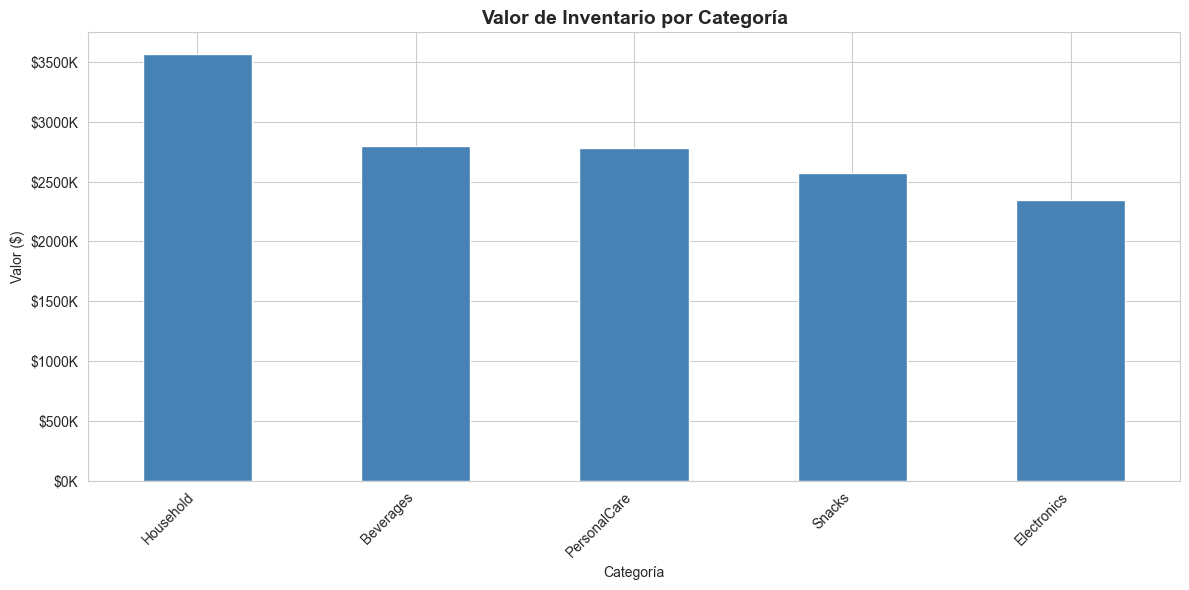

💡 Insight: La categoría 'Household' concentra $3,568,942 (25.4%) del valor total


In [15]:
# Visualización 1: Valor de inventario por categoría
viz1_data = fact_inventory_final.merge(
    dim_product[['product_key', 'category']], on='product_key'
).groupby('category')['inventory_value'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
viz1_data.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Valor de Inventario por Categoría', fontsize=14, fontweight='bold')
ax.set_xlabel('Categoría')
ax.set_ylabel('Valor ($)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"💡 Insight: La categoría '{viz1_data.index[0]}' concentra ${viz1_data.values[0]:,.0f} ({viz1_data.values[0]/viz1_data.sum()*100:.1f}%) del valor total")

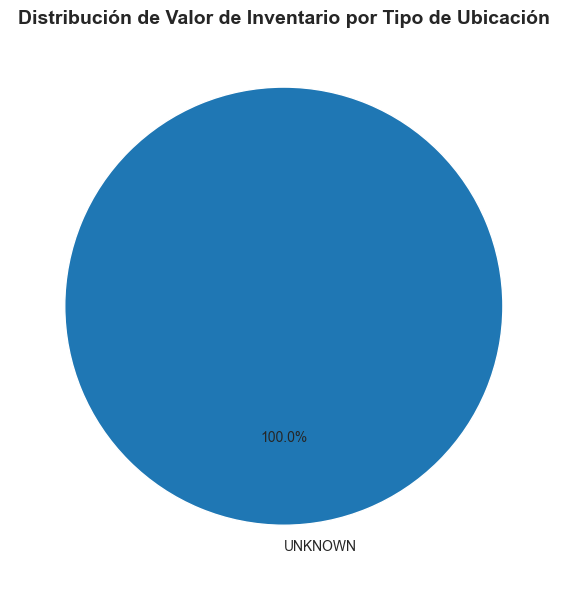

In [16]:
# Visualización 2: Distribución de inventario por tipo de ubicación
viz2_data = fact_inventory_final.merge(
    dim_location[['location_key', 'location_type']], on='location_key'
).groupby('location_type')['inventory_value'].sum()

fig, ax = plt.subplots(figsize=(10, 6))
viz2_data.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribución de Valor de Inventario por Tipo de Ubicación', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## 💾 Paso 8: Exportar Modelo Dimensional

Guardamos las tablas dimensionales en formato Parquet para uso posterior.

In [17]:
# Crear directorio de salida
output_path = Path('../../data/processed/dimensional_model')
output_path.mkdir(parents=True, exist_ok=True)

# Exportar dimensiones y hechos
dim_date.to_parquet(output_path / 'dim_date.parquet', index=False)
dim_product.to_parquet(output_path / 'dim_product.parquet', index=False)
dim_location.to_parquet(output_path / 'dim_location.parquet', index=False)
fact_inventory_final.to_parquet(output_path / 'fact_inventory_daily.parquet', index=False)

print("✅ Modelo dimensional exportado exitosamente")
print(f"📁 Ubicación: {output_path.absolute()}")
print("\n📦 Archivos generados:")
for file in output_path.glob('*.parquet'):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  - {file.name}: {size_mb:.2f} MB")

✅ Modelo dimensional exportado exitosamente
📁 Ubicación: f:\GitHub\supply-chain-data-notebooks\notebooks\20_data_architecture\..\..\data\processed\dimensional_model

📦 Archivos generados:
  - dim_date.parquet: 0.01 MB
  - dim_location.parquet: 0.01 MB
  - dim_product.parquet: 0.01 MB
  - fact_inventory_daily.parquet: 0.03 MB


## 📚 Resumen y Conclusiones

### ✅ Lo que logramos:
1. ✅ **Modelo dimensional tipo estrella** con 3 dimensiones + 1 tabla de hechos
2. ✅ **Surrogate keys** para independencia de sistemas source
3. ✅ **Jerarquías navegables:** Categoría → Subcategoría → SKU | Región → Ciudad → Ubicación
4. ✅ **Métricas precalculadas:** Valor de inventario para performance
5. ✅ **Queries optimizadas:** Análisis multidimensionales con JOINs simples

### 🎯 Aplicaciones prácticas:
- **Dashboards BI:** Conexión directa a Power BI, Tableau, Looker
- **Cubos OLAP:** Pre-agregaciones para queries subsegundo
- **Machine Learning:** Features estructuradas para modelos predictivos
- **Auditorías:** Trazabilidad histórica de inventarios

### 🚀 Próximos pasos:
1. Implementar **SCD Type 2** en dim_product para rastrear cambios de precio/categoría
2. Agregar dimensión `dim_inventory_status` (disponible, reservado, dañado)
3. Crear **agregados** mensuales para optimizar queries de largo plazo
4. Implementar **particionamiento** por fecha en la tabla de hechos
5. Añadir métricas calculadas: rotación, cobertura, obsolescencia

### 📖 Referencias:
- Kimball, R. & Ross, M. (2013). *The Data Warehouse Toolkit*
- Inmon, W.H. (2005). *Building the Data Warehouse*